# SCF Examples

This notebook shows the spherical correlation function (SCF) of several modes of digital communications. 

## Analog Modulation
In analog communications we encode continuous valued signals on top of a carrier frequency. Information can be encoded in the amplitude , for example: amplitude modulation (AM) or single sideband (SSB). It can also be encoded in the phase, for example: phase modulation or frequency modulation or encoded in both phase and amplitude. One of the issues with analog modulation is that you can never get the signal you are transmitting exactly recovered. It will always be contaminated by system imperfections, noise and other deviations. 
At the same time, analog communication offeres simple implementations as well as robustness because signals often degrade gracefully and information can still be extracted from them even with severe interferences and low signal to noise ratio.

## Digital Modulation
In contrast, in digital communications we transmit quantaized digital data. Because the information is digital, this form of communications offers the advantage of a perfect reproduction of the transmitted signal. Much like analog communications, digital data can be encoded in many different ways using phase, amplitude and frequency. It can be encoded using a binary stream in which '0's and '1's are transmitted in each time interval. It can also be encoded with M-ary symbols, in which higher order symbols (for example 4-ary 0,1,2,3) are transmitted in each time interval. 








In [1]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import threading,time
import sys
import cyclostationary

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import integrate

import threading,time
import multiprocessing

from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread


%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m//2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m//2,:],dbf=dbf)
        print(1)
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

### Example of Different Digital Modulations:

In the following sections we will consider signals with a symbol-rate of 300 bauds (300b/s) with a carrier frequency of 1800Hz and a sampling rate of 44100. Each bit will correspond to 44100/300 = 147 samples. The carrier frequency was chosen such that there exactly 6 cycles in a bit -- this is useful for the phase-based modulation schemes. 

In [3]:
fs = 44100  # sampling rate
baud = 300  # symbol rate
Nbits = 10  # number of bits
Ns = fs//baud
N = Nbits * Ns
f0 = 1800
bits = randn(Nbits,1) > 0

#### Amplitude-Shift-Keying (ASK) or On-Off Keying (OOK) 
ASK/OOK encodes digital data in the amplitude of the carrier, $M(t)\cos(2\pi f_0t)$ where $M(t) = \{0~or~1\}$ for binary data. We saw such an example in the ADS-B mode S lab previously. M-ary digital data can also be encoded in the amplitude by dividing the amplitude into more segments. For example $M(r) = \{0~or~0.33~or~0.66~or~1.0\}$ for a 4-ary symbol

Here's an example of an OOK signal:

[0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 3.32653061e-02
 3.32879819e-02 3.33106576e-02]


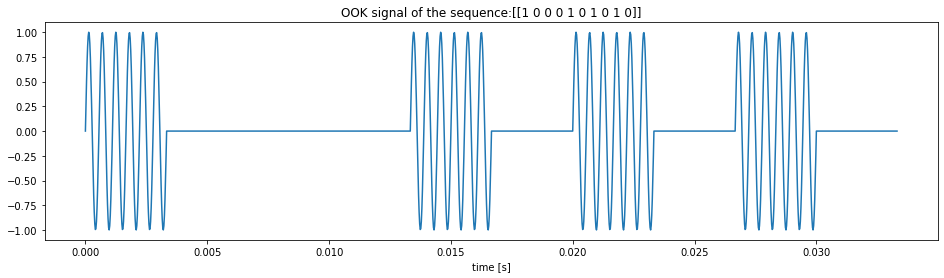

In [4]:
np.random.seed(seed=1)
bits = randn(Nbits,1) > 0
M = np.tile(bits,(1,Ns))
t = r_[0.0:N]/fs
OOK = M.ravel()*sin(2*pi*f0*t)

fig = figure(figsize = (16,4))
plot(t,OOK)
xlabel('time [s]')
title('OOK signal of the sequence:'+ np.array2string(transpose(np.uint8(bits))))
print(t)

The approach of using OOK/ASK as above is not ideal. We can see this by plotting the spectrum

* Compute the spectrum of the above ook signal using FFT, and plot its magnitude. 
* Comment on the spectrum. What is the issue that may arise if one would like to transmit at nearby frequencies?

(0, 4096, 0, 294.0)

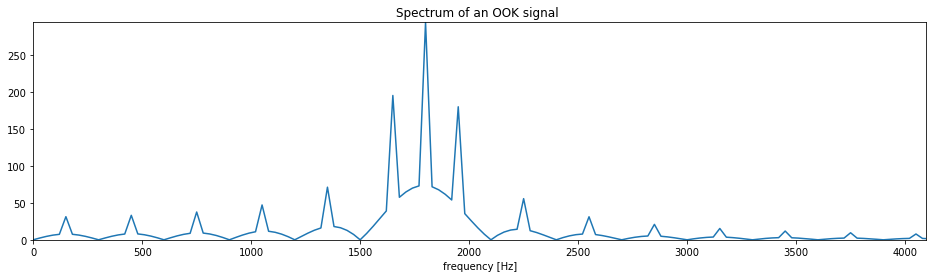

In [5]:
f = r_[0:N//2]/N*fs

OOK_f = (np.fft.fft(OOK))

fig = figure(figsize = (16,4))
plot(f,abs(OOK_f[:len(OOK_f)//2]))
xlabel('frequency [Hz]')
title('Spectrum of an OOK signal ')
axis((0,4096,0,max(abs(OOK_f))))

Now we compute and plot the scf

nx= 256
my, mx 64 512


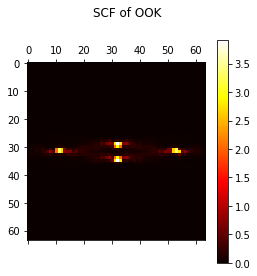

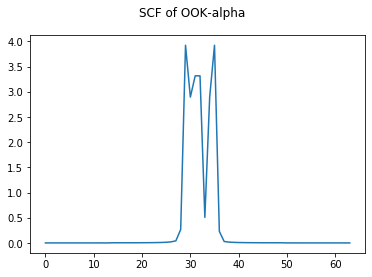

In [6]:
def plotfam(x, t):
    Np = 64
    L = 1
    B = 32 # how far around the center we look
    xs = x[:512]
    nx = len(xs) // 2 # center of X axis
    print("nx=", nx)
    
    # do analysis
    s = cyclostationary.scd_fam(xs, Np, L)
    f = np.absolute(s)
    alpha = cyclostationary.alphaprofile(s)
    (my, mx) = f.shape 
    print("my, mx", my, mx)
    f = f[(my//2-B):(my//2+B), (mx//2-B):(mx//2 + B)]
    
    # plot SCD graph
    plt.matshow(f, cmap='hot')
    plt.suptitle(t)
    plt.colorbar()
    plt.show()
    
    # plot alphaprofile graph
    plt.plot(alpha)
    plt.suptitle(t + "-alpha")
    plt.show()
    
plotfam(OOK, "SCF of OOK")

Instead of using rectangular pulses, we can use shaped pulses which have more narrowband frequency response.  For example, we could use sinc based pulses that would result in bandlimited spectrum. Of course it is not practical to use a sinc, since it is infinite in length. Instead we can use a truncated (windowed) sinc pulses with certain time bandwidth (TBW) product that would have a finite length as well as narrow bandness. While here we use a windowed sinc function as we learned in class, in the communications community the raised cosine filter is often used. A raised cosing  is a tapered sinc function (with parameter $0\leq \beta \leq 1$) in which the impulse response and spectrum looks like:
<br>
<center> <img src="http://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Raised-cosine-impulse.svg/1200px-Raised-cosine-impulse.svg.png" alt="Raised-cosine-impulse.svg"style="width: 470px; float: left" style="float:left;" \> <img src="http://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/Raised-cosine_filter.svg/1200px-Raised-cosine_filter.svg.png" alt="Raised-cosine filter.svg" style="width: 470px; float: left"  \> </center>

<br><br><br>


For more information about the raised cosine function look [here](http://www.commsys.isy.liu.se/TSKS04/lectures/3/MichaelZoltowski_SquareRootRaisedCosine.pdf)


Now, going back to thinking in terms of the time-bandwidth product (TBW), the TBW of a rectangular pulse is 1, so for a symbol length of 1/300 seconds we get a bandwidth of 300 Hz (The the main lobe full width at half the maximum) but lots of ripple. We could use a TBW = 2 pulse (like a hamming window or higher order pulses. 

* Using the random bit sequence chosen above, generate a new sequence with either zero or discrete impulses spaced fs/baud samples apart. For example a sequence of 1010 would have an impulse at position 0, an impulse at position 294 and zeros elsewhere
* Generate a TBW = 4  windowed sinc pulse with zero-crossing occuring every 147 samples. 
* Convolve the sinc with the impulse train to generate a sinc OOK/ASK signal. 
* modulate the result to 1800Hz
* Plot the signal and its spectrum
* Comment on the separation between on and off.... what happened? Comment on the spectrum.

nx= 256
my, mx 64 512


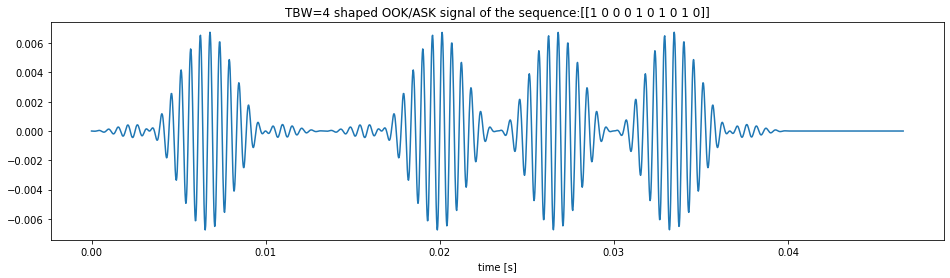

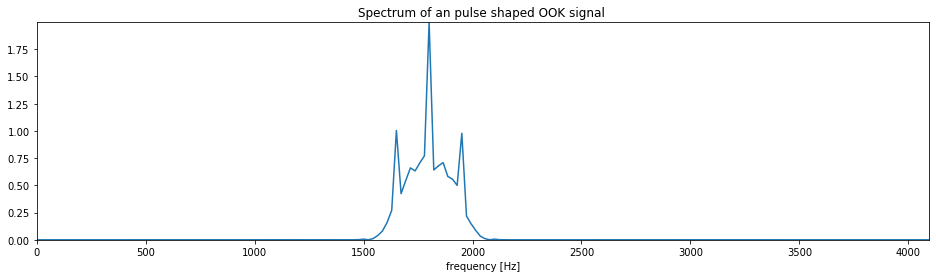

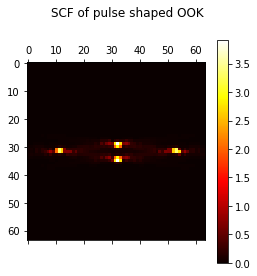

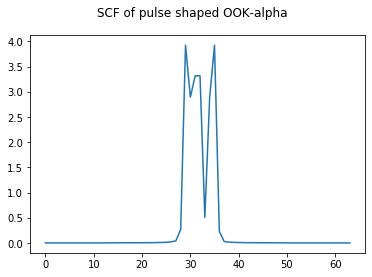

In [7]:
imp = zeros(N)
imp[::Ns] = bits.ravel()

h = signal.firwin(Ns*4,1.0/Ns)
imp_sinc = signal.fftconvolve(imp,h,mode='full')
t = r_[0.0:len(imp_sinc)]/fs
OOK_s = imp_sinc*sin(2*pi*f0*t)


fig = figure(figsize = (16,4))
plot(t,OOK_s)
xlabel('time [s]')
title('TBW=4 shaped OOK/ASK signal of the sequence:'+ np.array2string(transpose(np.uint8(bits))))

f = r_[0:len(imp_sinc)/2.0]/len(imp_sinc)*fs
OOK_sf = (np.fft.fft(OOK_s))

fig = figure(figsize = (16,4))
plot(f,abs(OOK_sf[0:len(OOK_sf)//2+1]))
xlabel('frequency [Hz]')
title('Spectrum of an pulse shaped OOK signal ')
axis((0,4096,0,max(abs(OOK_sf))))
plotfam(OOK, "SCF of pulse shaped OOK")

Answer:

What we see is that the bandwidth become narrow. At the same time, we see leakage between bits. This is called inter-symbol interference and can cause errors in the detection when there are certain delays that occur between the receiver and the transmitter. 

#### Phase-shift-keying (PSK) 
PSK encodes digital data in the phase of the signal.  For example, Binary PSK (BPSK) sends a stream of '0's and '1's by alternating the sign of the carrier in each bit period: $Real \left \{ e^{\pi M(t)}\cos(2\pi f_0t) \right \}$, where $M(t)$ is a signal of $0~or~1$ corresponding to '0's and '1's. The RDS subcarrier in FM radio is BPSK encoded. Also, [PSK31](http://en.wikipedia.org/wiki/PSK31) is a very popular text-to-text ham radio protocol for HF that has 31b/s rate, which matches a typical keyboard typing rate. An M-ary symbol can be transmitted by MPSK in which $M(t)$ are broken to smaller intervals. For example in 4 PSK (QPSK) 0,1,2,4 are encoded in $M(t) = \{0~or~0.5~or~1~or~1.5\}$. It could also be encoded in a $45^\circ$ rotated constellation $M(t) = \{0.25~or~0.75~or~1.25~or~1.75\}$ 

Here's an example of a BPSK signal:

Text(0.5, 1.0, 'BPSK signal of the sequence:[[1 0 0 0 1 0 1 0 1 0]]')

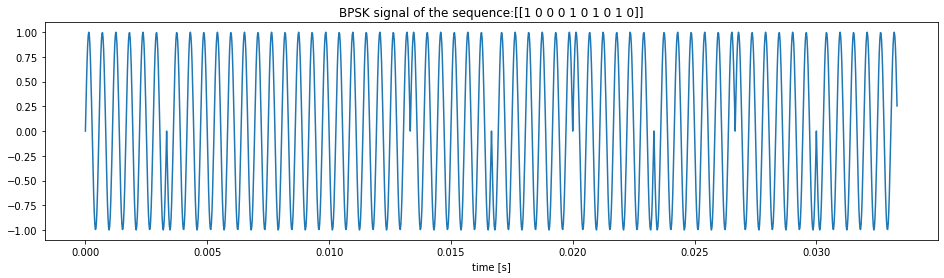

In [8]:
np.random.seed(seed=1)
bits = randn(Nbits,1) > 0 
M = np.tile(bits*2-1,(1,Ns))
t = r_[0.0:N]/fs
BPSK = M.ravel()*sin(2*pi*f0*t)

fig = figure(figsize = (16,4))
plot(t,BPSK)
xlabel('time [s]')
title('BPSK signal of the sequence:'+ np.array2string(transpose(np.uint8(bits))))

One of the advantages of PSK is that the envelope of the signal is constant. This means that we don't have to use linear amplifiers (also called class A or AB) in order to amplify the signal for transmission. Instead we can use the much more efficient non-linear amplifiers (class C or E). However, the problem is of course that the phase has a discontinuity. This will have an effect on the spectrum. 

* Compute the spectrum of the above BPSK signal. Comment on the spectrum

nx= 256
my, mx 64 512


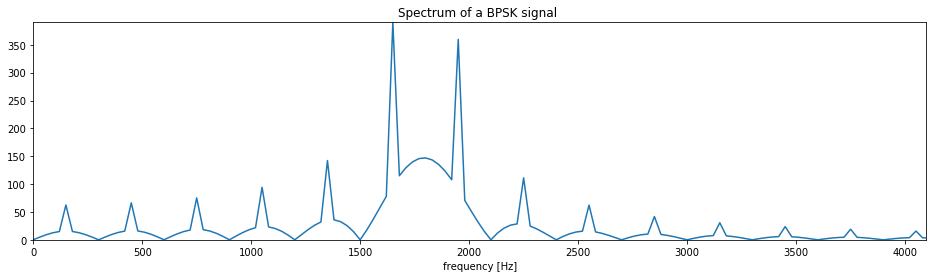

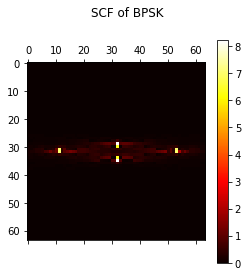

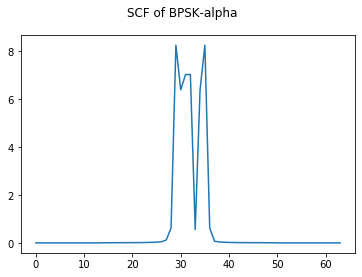

In [9]:
f = r_[0:N/2.0]/N*fs

BPSK_f = (np.fft.fft(BPSK))

fig = figure(figsize = (16,4))
plot(f,abs(BPSK_f[0:len(BPSK_f)//2]))
xlabel('frequency [Hz]')
title('Spectrum of a BPSK signal ')
axis((0,4096,0,max(abs(BPSK_f))))
plotfam(BPSK, "SCF of BPSK")

We can use the same "trick" as before and shape the pulses with a windowed sinc function. 

* Repeat the procedure for the case of BPSK similarly to the shaped ASK/OOK as before. However instead of a zero-one pulse train use a $\pm 1$ train to get the changes in phase. 
* What did we win and what did we lose?  Comment on the spectrum the symbol leakage and the envelope of the signal.

nx= 256
my, mx 64 512


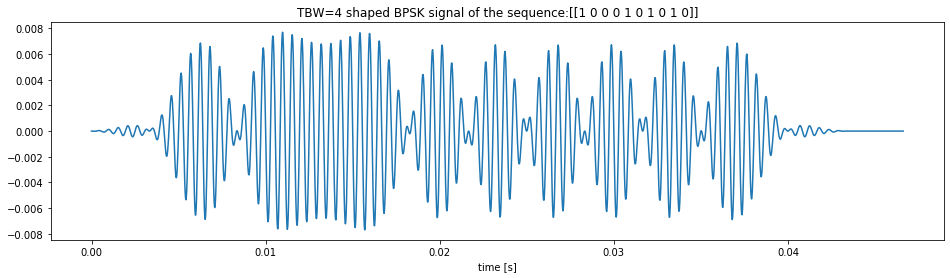

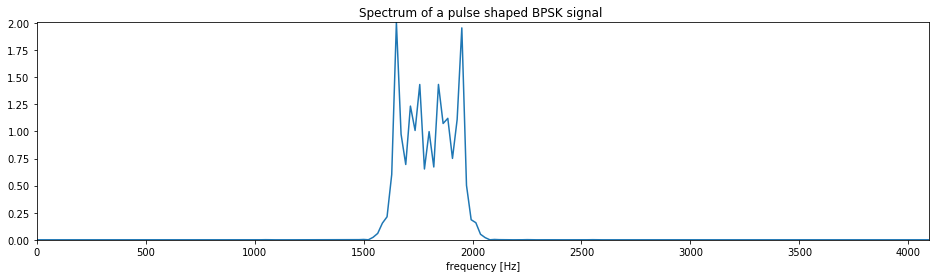

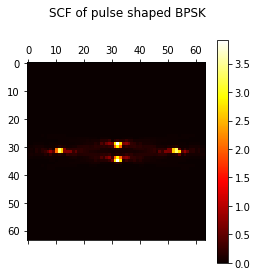

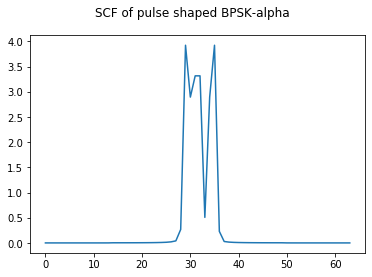

In [10]:
imp = zeros(N)
imp[::Ns] = bits.ravel()*2-1

h = signal.firwin(Ns*4,1.0/Ns)
imp_sinc = signal.fftconvolve(imp,h,mode='full')
t = r_[0.0:len(imp_sinc)]/fs
BPSK_s = imp_sinc*sin(2*pi*f0*t)


fig = figure(figsize = (16,4))
plot(t,BPSK_s)
xlabel('time [s]')
title('TBW=4 shaped BPSK signal of the sequence:'+ np.array2string(transpose(np.uint8(bits))))

f = r_[0:len(imp_sinc)/2.0]/len(imp_sinc)*fs
BPSK_sf = (np.fft.fft(BPSK_s))

fig = figure(figsize = (16,4))
plot(f,abs(BPSK_sf[0:len(BPSK_sf)//2+1]))
xlabel('frequency [Hz]')
title('Spectrum of a pulse shaped BPSK signal ')
axis((0,4096,0,max(abs(BPSK_sf))))
plotfam(OOK, "SCF of pulse shaped BPSK")

#### Quadrature-Amplitude-Modulation (QAM)
QAM encodes M-arry digital data in both the amplitude and phase, i.e., $Real \left \{ M(t)\cos(2\pi f_0t) \right \}$ where M(t) have an amplitude and phase that divides the complex plane into M segments. 
QAM is heavily used in cable TV and modems. You can see constellations of QAM-16 to QAM-256 which break the complex plane to $4\times 4$ and $16\times 16$ grids. 
 
Here's an image of the constallation of QAM-16:
<center><img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/lab3/QAM16.png" alt="qam16" style="width: 250px;"/></center>
<center>Figure 1: QAM-16 Constallation</center>


Text(0.5, 1.0, 'QAM=16 of the sequence:[[ 6 11  0  4  2  1  2  5  6  8  6 10  3 14  0 10]]')

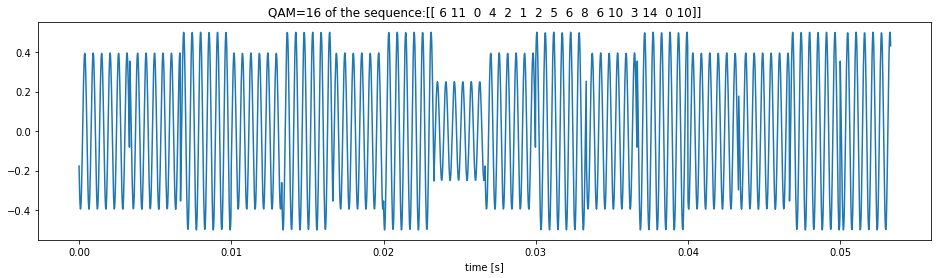

In [11]:
#code = { 2: -2+2j, 6: -1+2j, 14: 1+2j, 10: 2+2j,
#        3: -2+1j, 7: -1-1j, 15: 1+1j, 11: 2+1j,
#        1: -2-1j, 5: -1-1j, 13: 1-1j, 9: 2-1j,
#        0: -2-2j, 4: -1-2j, 12: 1-2j, 8: 2-2j}
Nbits = 16  # number of bits
N = Nbits * Ns
code = np.array((-2-2j, -2-1j,-2+2j,-2+1j,-1-2j,-1-1j,-1+2j,-1+1j,+2-2j,+2-1j,+2+2j,+2+1j,1-2j,+1-1j,1+2j,1+1j))/2
np.random.seed(seed=1)
bits = np.int16(rand(Nbits,1)*16) 
M = np.tile(code[bits],(1,Ns))
t = r_[0.0:N]/fs

# these are two ways of producing the same result:
#QAM = (M.real.ravel()*cos(2*pi*f0*t) - M.imag.ravel()*sin(2*pi*f0*t))/2/sqrt(2)
QAM = real(M.ravel()*exp(1j*2*pi*f0*t))/sqrt(2)/2
fig = figure(figsize = (16,4))
plot(t,QAM.real)
xlabel('time [s]')
title("QAM=16 of the sequence:"+ np.array2string(transpose(bits)))

QAM is a very efficient way to use the amplitude as well as the phase to encode M-arry symbols. 

* Compute the spectrum of the above QAM 16 signal. 
* Repeat the same for shaped TBW=4 pulses. 
* Is the bandwidth much different than the binary sequences? What is the bitrate improvement per bandwidth you get?

nx= 256
my, mx 64 512


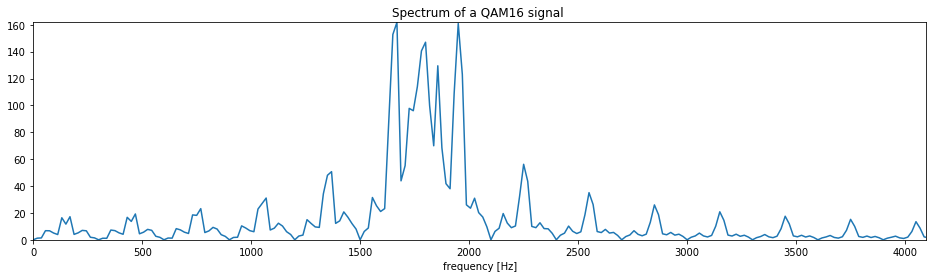

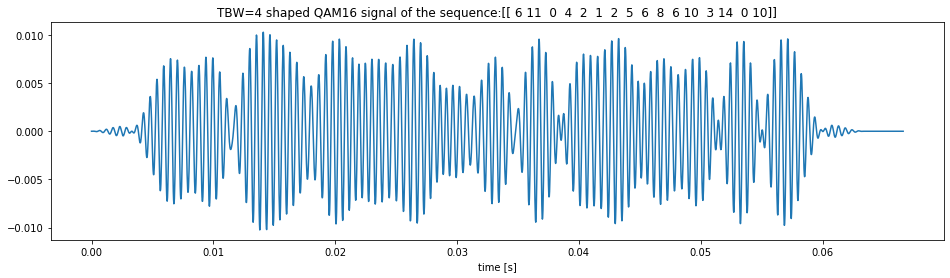

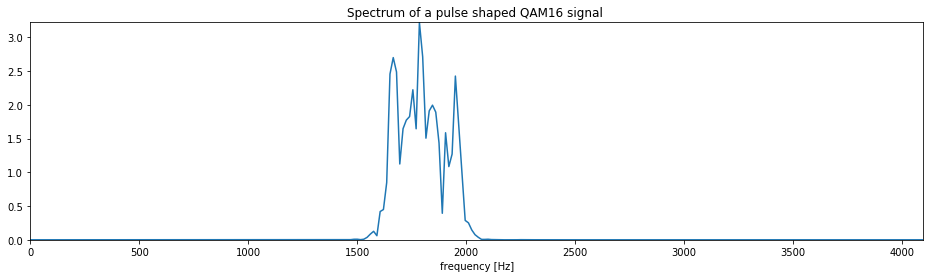

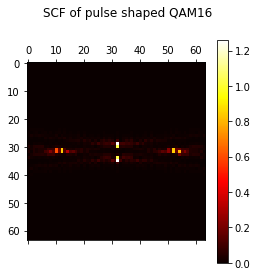

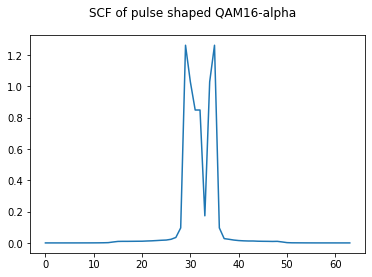

In [12]:
f = r_[0:N/2.0]/N*fs

QAM_f = (np.fft.fft(QAM))

fig = figure(figsize = (16,4))
plot(f,abs(QAM_f[0:len(QAM_f)//2]))
xlabel('frequency [Hz]')
title('Spectrum of a QAM16 signal ')
axis((0,4096,0,max(abs(QAM_f))))


imp = zeros(N,dtype='complex')
imp[::Ns] = code[bits].ravel()

h = signal.firwin(Ns*4,1.0/Ns)
imp_sinc = signal.fftconvolve(imp,h,mode='full')
t = r_[0.0:len(imp_sinc)]/fs
QAM_s = real(imp_sinc*exp(1j*2*pi*f0*t))


fig = figure(figsize = (16,4))
plot(t,QAM_s)
xlabel('time [s]')
title('TBW=4 shaped QAM16 signal of the sequence:'+ np.array2string(transpose(bits)))
f = r_[0:len(imp_sinc)/2.0]/len(imp_sinc)*fs
QAM_sf = (np.fft.fft(QAM_s))

fig = figure(figsize = (16,4))
plot(f,abs(QAM_sf[0:len(QAM_sf)//2+1]))
xlabel('frequency [Hz]')
title('Spectrum of a pulse shaped QAM16 signal ')
axis((0,4096,0,max(abs(QAM_sf))))
plotfam(QAM, "SCF of pulse shaped QAM16")

#### Frequency-Shift-Keying (FSK)
FSK encodes digital data in the frequency of the carrier, i.e., $\cos \left(2\pi (f_0 + M(t)\Delta f)t\right)$. For binary FSK (BFSK),  $M(t) =\{1~or~-1\}$. In M-arry FSK (MFSK) the frequency band can be broken to more segments. Again, much like PSK, FSK has also a constant envelope which makes it ideal for use with efficient non-linear amplifiers. 

The choise of frequencies has a huge impact on our ability to demodulate the signal as well as the bandwidth of it.  For example, we would like the frequencies to be orthogonal over a bit period so when detected using correlation we will ge the maximum difference between the results. We would also like the phase to be continuous for the sidelobes to decay rapidly and not interfere with nearby channels.  

For example, the choice of frequencies of 1200Hz and 2400Hz below for a bitrate of 300 baud results in 4 and 8 cycles per bit period respectively. The outcome is a smooth phase and orthogonal frequencies. 

Text(0.5, 1.0, 'FSK signal of the sequence:[[1 0 0 0 1 0 1 0 1 0]]')

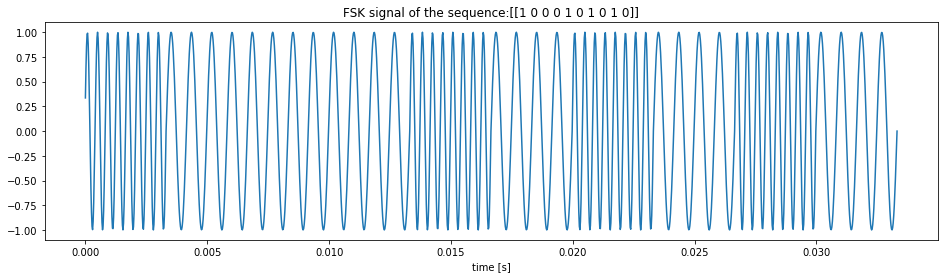

In [13]:
np.random.seed(seed=1)
Nbits = 10
N = Nbits * Ns
bits = randn(Nbits,1) > 0 
M = np.tile(bits*2-1,(1,Ns))
delta_f = 600


# compute phase by integrating frequency
ph = 2*pi*cumsum(f0 + M.ravel()*delta_f)/fs
t = r_[0.0:N]/fs
FSK = sin(ph)

fig = figure(figsize = (16,4))
plot(t,FSK)
xlabel('time [s]')
title('FSK signal of the sequence:'+ np.array2string(transpose(np.uint8(bits))))

* Compute the spectrum of the above FSK signal. Can you see the frequencies?


nx= 256
my, mx 64 512


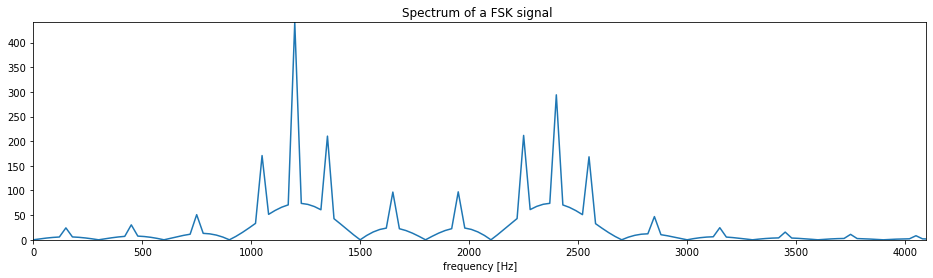

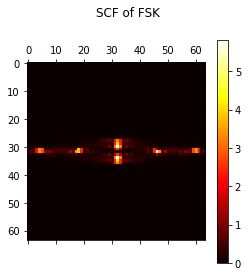

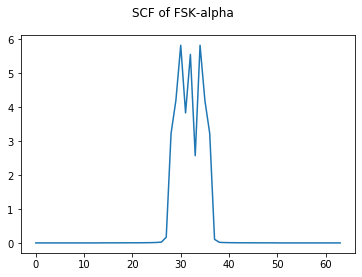

In [14]:
f = r_[0:N/2.0]/N*fs

FSK_f = (np.fft.fft(FSK))

fig = figure(figsize = (16,4))
plot(f,abs(FSK_f[0:len(FSK_f)//2]))
xlabel('frequency [Hz]')
title('Spectrum of a FSK signal ')
axis((0,4096,0,max(abs(FSK_f))))
plotfam(FSK, "SCF of FSK")

The reason the frequencies are separated well is the low bit-rate.
For the same choice of frequencies we can increase the baud (i.e. the bit-rate) and still get continuous phase and orthogonal frequencies. For example: with a 600 bause we will get 2 cycles for 1200Hz and 4 cycles for 2400Hz per bit period. We can continue further for 1200baud which results in 1cycle/2cycle for 1200Hz/2400Hz. 

Finally, the highest rate in which we can get orthogonal frequencies is 2400 baud. In that case, we will have 1/2 a cycle at 1200Hz and 1 cycle for 2400Hz. The phase will still be continuous and the frequencies orthogonal.  This form of FSK modulation is also called Minimum-Shift-Keying (MSK) and is generalized to the case where the frequency difference is half the bit-rate.

* What would be the choice of frequencies for a 300 baud MSK centered at 1800Hz?
* Generate the MSK-300 modulation of the above signal.
* Plot the signal as well as its spectrum and spectrogram For the spectrogram use 148 window (which is approximately the bit length). Comment on the bandwidth of the signal compared to the BFSK above.

1
nx= 256
my, mx 64 512


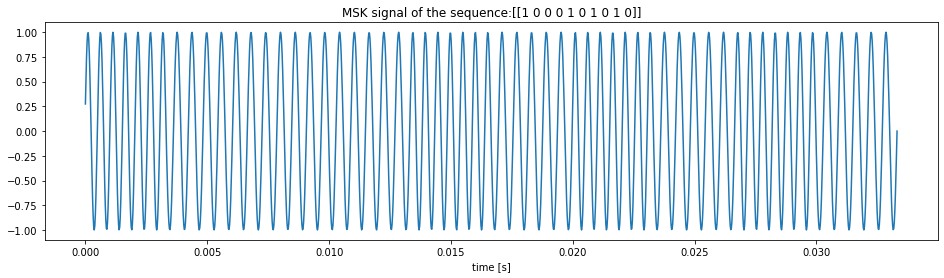

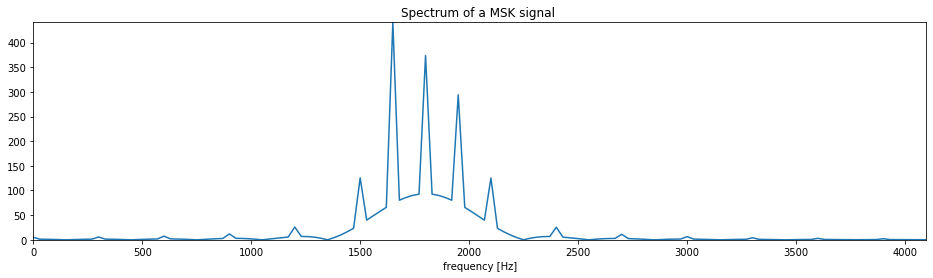

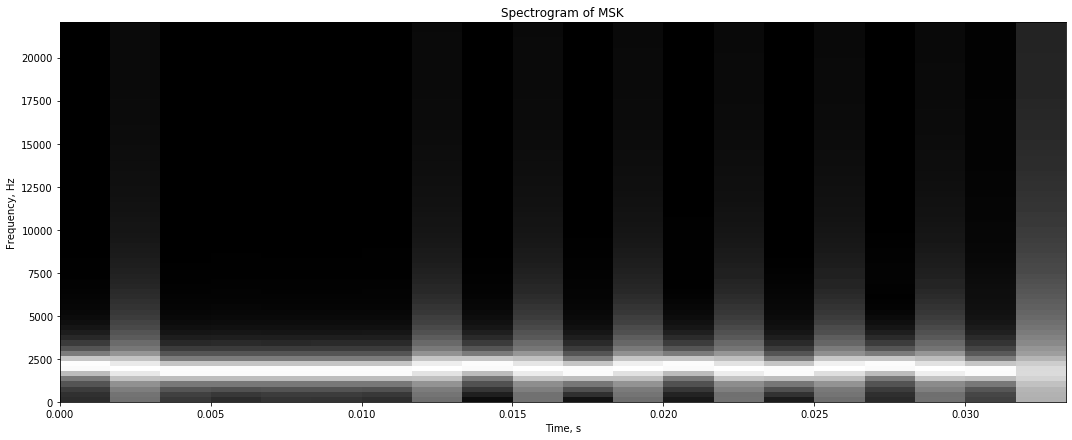

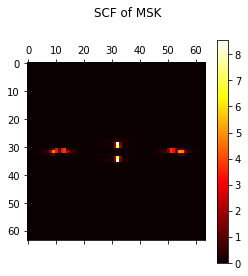

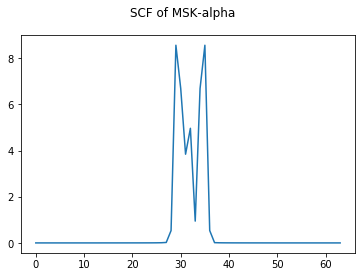

In [15]:
delta_f = 150
ph = 2*pi*cumsum(f0 + M.ravel()*delta_f)/fs
t = r_[0.0:N]/fs
MSK = sin(ph)

fig = figure(figsize = (16,4))
plot(t,MSK)
xlabel('time [s]')
title('MSK signal of the sequence:'+ np.array2string(transpose(np.uint8(bits))))

f = r_[0:N/2.0]/N*fs

MSK_f = (np.fft.fft(MSK))

fig = figure(figsize = (16,4))
plot(f,abs(MSK_f[0:len(MSK_f)//2]))
xlabel('frequency [Hz]')
title('Spectrum of a MSK signal ')
axis((0,4096,0,max(abs(MSK_f))))
tt,ff,xmf = myspectrogram_hann_ovlp(MSK, 148, 44100.0, 0,dbf = 60)
title('Spectrogram of MSK')
plotfam(MSK, "SCF of MSK")


MSK is a very efficient modulation with constant envelope and a narrow bandwidth. However its sidelobes are still prohibitly high for application like cellphone networks. The sidelobes can be further reduce by prefiltering the frequency transition by a smoothing filter. A very common filter is a gaussian filter. When a gaussian filter is used, the modulation is called GMSK. This is the modulation that is used for GSM networks. Much like the other modulations, filtering reduces the sidelobes, but increase the inter-symbol interference. 

The Gaussian filter used in GMSK is defined as:
$$ h(t) = \sqrt{\frac{2\pi}{\mathrm{log} 2}} \cdot BW \mathrm{exp}\left(-\frac{2\pi^2(BW)^2}{\mathrm{log}2}t^2\right) $$, 
where BW is determined by the time-bandwidth product (TBW) and the duration of the gaussian pulse, which is $\frac{T_b}{TBW}$ -- where $T_b$ is the bit time-period.  

In the discrete case, where $f_s$ is the sampling frequency 
$$ h[n] = \sqrt{\frac{2\pi}{\mathrm{log} 2}} \cdot \frac{BW}{f_s} \mathrm{exp}\left(-\frac{2\pi^2}{\mathrm{log}2}\frac{(BW)^2}{f_s^2}n^2\right) $$, 

* Generate a TBW=0.5 gaussian filter over a 2bit time period. What is the bandwitdh?
* Plot the filter. 
* Filter the frequency of the MSK signal above using the gaussian filter.  Integrate to generate the phase to generate the  modulated signal as above. 
* Plot the signal and its spectrum. Comment on the result. Does the spectrum have less sidelobes? 
* Explain why the spectrum looks like it is and compare to the spectrogram.  

1
nx= 256
my, mx 64 512


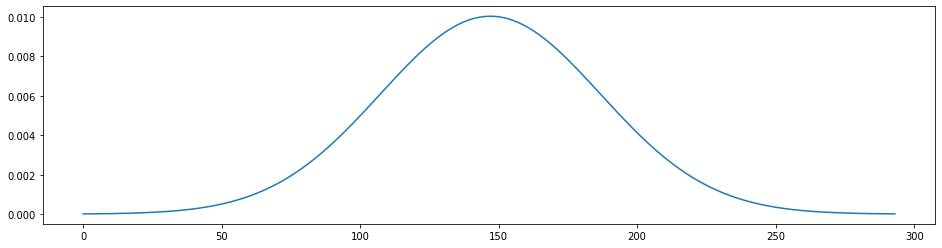

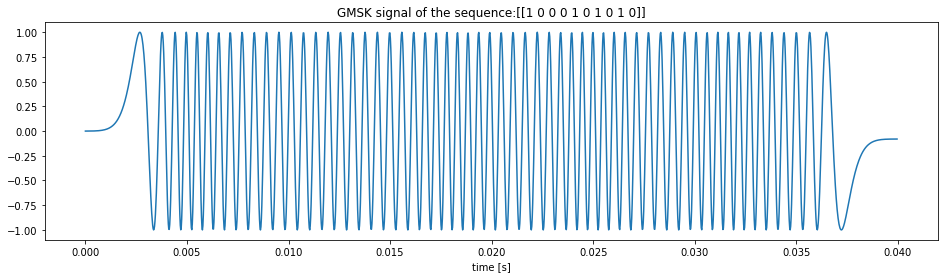

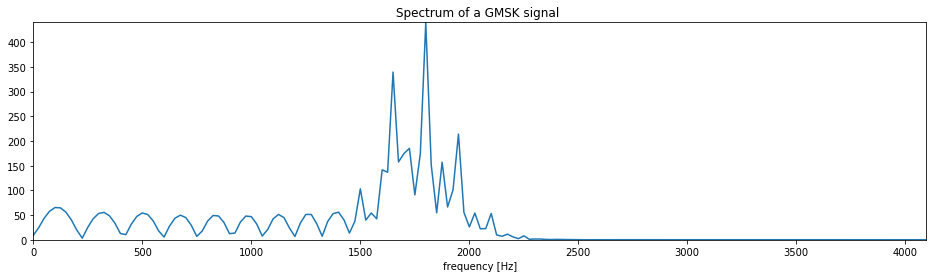

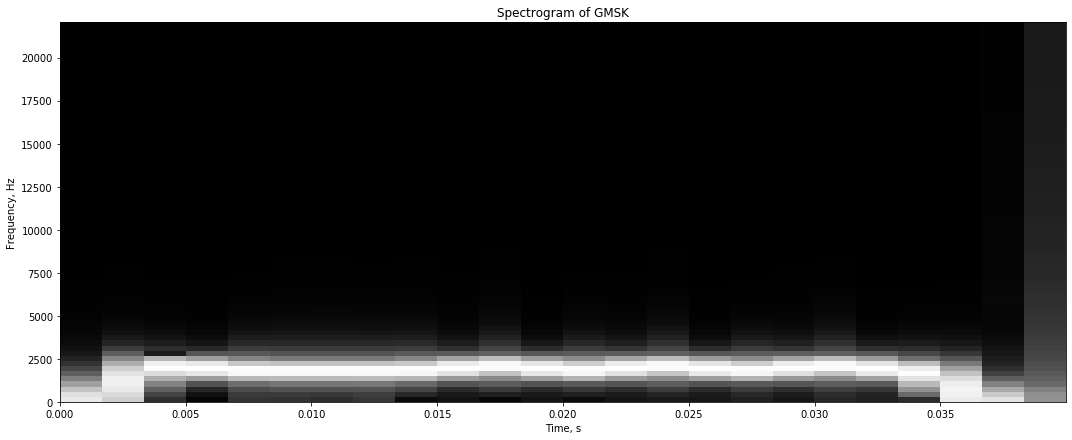

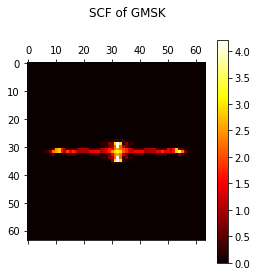

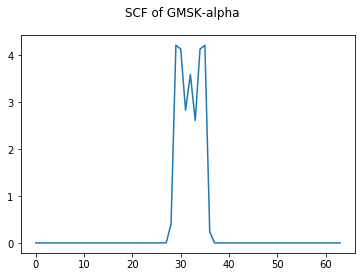

In [16]:

TBW =0.5
Tb = 294
B = Tb*TBW
n = r_[-Tb/2:Tb/2]
h = sqrt(2*pi/log(2))*B/fs*exp(-2*pi*pi*B*B*n*n/fs/fs/log(2))


fig = figure(figsize = (16,4))
plot(h)

freq = signal.fftconvolve(f0 + M.ravel()*delta_f,h)
ph = 2*pi*cumsum(freq)/fs
t = r_[0.0:N]/fs
GMSK = sin(ph)

t = r_[0.0:len(GMSK)]/fs
fig = figure(figsize = (16,4))
plot(t,GMSK)
xlabel('time [s]')
title('GMSK signal of the sequence:'+ np.array2string(transpose(np.uint8(bits))))

f = r_[0:len(GMSK)/2.0]/len(GMSK)*fs

GMSK_f = (np.fft.fft(GMSK))

fig = figure(figsize = (16,4))
plot(f,abs(GMSK_f[0:len(GMSK_f)//2+1]))
xlabel('frequency [Hz]')
title('Spectrum of a GMSK signal ')
axis((0,4096,0,max(abs(GMSK_f))))
tt,ff,xmf = myspectrogram_hann_ovlp(GMSK, 148, 44100.0, 0,dbf = 60)
title('Spectrogram of GMSK')
plotfam(GMSK, "SCF of GMSK")

Plot them all again together so it is easy to compare

nx= 256
my, mx 64 512


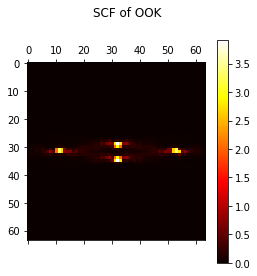

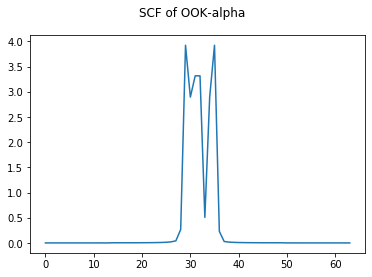

nx= 256
my, mx 64 512


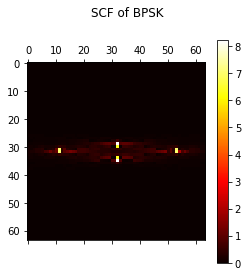

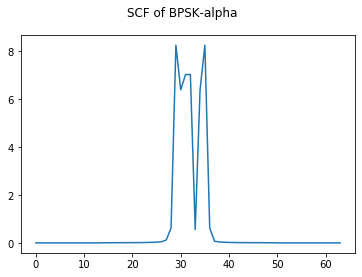

nx= 256
my, mx 64 512


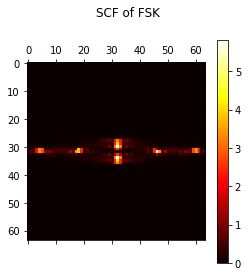

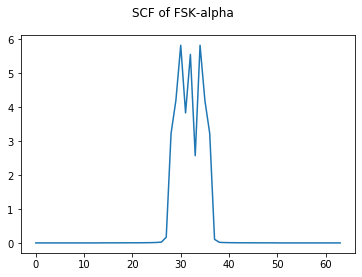

nx= 256
my, mx 64 512


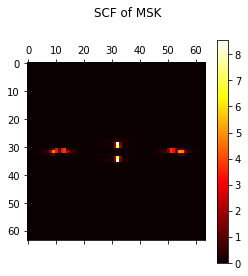

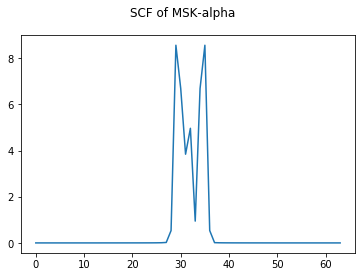

nx= 256
my, mx 64 512


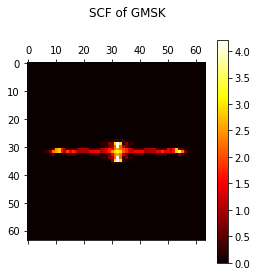

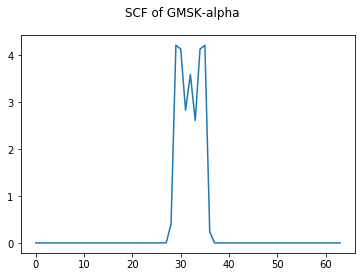

In [17]:
plotfam(OOK, "SCF of OOK")
plotfam(BPSK, "SCF of BPSK")
plotfam(FSK, "SCF of FSK")
plotfam(MSK, "SCF of MSK")
plotfam(GMSK, "SCF of GMSK")